In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Alphabet import generic_protein
import re

In [3]:
# read in neut data

neut_file_path = '../data/2F5_IC50_IC80.txt'

neuts = pd.read_table(neut_file_path, header=0)
neuts.rename(columns={'Virus name':'name', 
              'Subtype':'subtype',
              '2F5: IC50 geometric mean':'IC50',
              '2F5: IC80 geometric mean':'IC80'}, inplace=True)
# neuts.set_index('name', inplace=True)
neuts.drop(['Tier', 'Country', 'Accession', 'Alias', 'Seq data', 
            ' 2F5: IC50 by study', ' 2F5: IC80 by study', 'Unnamed: 11'], 
            axis=1, inplace=True)
neuts = neuts[neuts.name != 'Geometric mean of detected']
neuts = neuts[neuts.name != 'Geometric mean of all(undetected set to 100)'] 
neuts = neuts[neuts.name != '% detected (detected/total)'] 

In [4]:
# read in sequence data

virus_name = []
virus_seq = []
passed_seqs = []

fasta_file_path = '../data/2F5 virus aa align.fasta'

for seq_record in SeqIO.parse(fasta_file_path, 'fasta', 
                              alphabet=generic_protein):
    try:
        virus_name.append(seq_record.id.split('.')[2])
        virus_seq.append(seq_record.seq)
    except:
        passed_seqs.append(seq_record)

HXB2 = passed_seqs[0]

In [5]:
# convert sequence data to DataFrame

seq_dict = {'sequence' : pd.Series(virus_seq, index=virus_name, 
                                   dtype='object')}
seq_df = pd.DataFrame(seq_dict)

In [6]:
# merge neuts and seq_df

neutdf = pd.merge(neuts, seq_df, how='inner', left_on='name', 
                    right_index=True)

In [7]:
# define neut categories

def binarize_IC50(row):
    if '>' in row.IC50:
        return 0
    else:
        value = float(row.IC50)
        return 0 if value > 50 else 1

neutdf['is_neutralized'] = neutdf.apply(binarize_IC50, axis=1)


In [8]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized
0,0013095_2_11,C,UD:>50,UD:>50,"(M, R, V, K, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0
1,001428_2_42,C,UD:>50,UD:>50,"(M, R, V, R, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0
2,0041_V3_C18,C,UD:>50,-,"(M, R, V, R, G, I, L, R, N, W, -, Q, L, W, W, ...",0
3,0077_V1_C16,C,UD:>50,UD:>50,"(M, R, V, M, G, S, M, R, N, C, -, Q, R, W, W, ...",0
4,00836_2_5,C,UD:>50,UD:>50,"(M, R, V, R, G, I, R, R, N, Y, -, Q, H, W, W, ...",0


# Feature Extraction

    Tokenize sequences w/ position value and amino acid identity
    Tokenize PNGS sites with a regex
    Vectorize tokens and create dataframe of dummy variables
    

In [9]:
# define function to tokenize sequence
# input = sequence object, output = dictionary where index is position and
# token is amino acid identity at that position

amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

def sequence_tokenizer(seq):
    """
    
    """
    seq_list = list(str(seq).strip('*'))
    working_peptide = list(enumerate(seq_list, start=1))
    peptide_dict = {}
    for index, amino in working_peptide:
        if amino in amino_acids:
            peptide_dict.update({index : amino})
        else: 
            pass
    return peptide_dict


In [10]:
# define function to tokenize potential N-linked glycosylation sites 
# (PNGS) in sequence
# input = sequence object, output = dictionary where index is position
# and token = 'PNGS'

def PNGS_tokenizer(seq):
    seq_string = str(seq).strip('*')
    PNGS_dict = {m.start(0)+1 : 'PNGS' 
                for m in re.finditer(r"N[^P][ST]", seq_string)}
    return PNGS_dict


In [11]:
# define feature extraction function where input = seq object and 
# output = one dictionary of all features

def get_features(seq, use_positions=True, use_PNGS=True):
    features = {}
    if use_positions:
        sequence_features = sequence_tokenizer(seq)
        features.update(sequence_features)
    if use_PNGS:
        PNGS_features = PNGS_tokenizer(seq)
        features.update(PNGS_features)
    return features


In [12]:
# map get_features function to sequence column of neutdf

neutdf['features_dict'] = neutdf.sequence.map(get_features)


In [13]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized,features_dict
0,0013095_2_11,C,UD:>50,UD:>50,"(M, R, V, K, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'K', 5: u'G', ..."
1,001428_2_42,C,UD:>50,UD:>50,"(M, R, V, R, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
2,0041_V3_C18,C,UD:>50,-,"(M, R, V, R, G, I, L, R, N, W, -, Q, L, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
3,0077_V1_C16,C,UD:>50,UD:>50,"(M, R, V, M, G, S, M, R, N, C, -, Q, R, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'M', 5: u'G', ..."
4,00836_2_5,C,UD:>50,UD:>50,"(M, R, V, R, G, I, R, R, N, Y, -, Q, H, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."


In [14]:
# vectorize data and build feature df

from sklearn.feature_extraction import DictVectorizer

d_vect = DictVectorizer()

list_features = list(neutdf.features_dict)
sparse_features = d_vect.fit_transform(list_features)
name_features = d_vect.get_feature_names()

features_df = pd.DataFrame(sparse_features.toarray(), columns=name_features)

features_df.head()

,100=A,100=D,100=K,100=N,100=R,100=S,100=T,101=P,102=H,102=I,...,99=P,9=D,9=G,9=H,9=I,9=K,9=N,9=R,9=S,9=T
0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [15]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[667]

791

In [16]:
# Examine features at positions 665 & 667 (MSA: 789 & 791)

epitope_features = [col for col in features_df.columns if '791' in col]
print epitope_features

['791=A', '791=D', '791=E', '791=G', '791=K', '791=N', '791=Q', '791=S', '791=T']


# Feature Selection

    Trim down feature outliers (highly conserved sequences & single variants)
    Other feature selection approaches (mRMR, incorporated methods)

In [17]:
# # define function to drop features that are shared by less than X% of sequences and/or more
# # than 1-X% of sequences

# def trim_feature_extremes(dataframe, percent_to_trim):
#     total_rows = dataframe.shape[0]
#     upper_threshold = (1 - percent_to_trim) * total_rows
#     lower_threshold = percent_to_trim * total_rows
#     column_filter_list = list((dataframe.sum(axis=0) >= lower_threshold) &
#                                 (dataframe.sum(axis=0) < upper_threshold)) 
#                                 #True = keep, False = drop
#     column_filter_dict = zip(list(dataframe.columns), column_filter_list)
#     columns_to_keep = [column for column, keepornot in column_filter_dict 
#                         if keepornot == True]
#     output_df = dataframe[columns_to_keep]
#     return output_df
 

In [18]:
# trimmed_feature_df = trim_feature_extremes(features_df, 0.05)

# trimmed_feature_df.shape

# Build Decision Tree Classifier

    Use for feature selection


In [19]:
# define X & y

X = features_df
y = neutdf.is_neutralized


In [20]:
# calculate best depth using roc_auc score

from sklearn.tree import DecisionTreeClassifier

max_depth_range = range(1, 101)

roc_auc_scores = []

from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treeclass = DecisionTreeClassifier(max_depth=depth)
    score = cross_val_score(treeclass, X, y, scoring='roc_auc', cv=10)
    roc_auc_scores.append(np.mean(score))
    
print roc_auc_scores

[0.89712931995540701, 0.95275501672240792, 0.94213628762541801, 0.92775153288740242, 0.91526142697881807, 0.92825989409141596, 0.92425097547380142, 0.90358695652173915, 0.88825808249721283, 0.88423801560758086, 0.89194397993311036, 0.89029264214046822, 0.90732162764771451, 0.88633500557413603, 0.90054905239687844, 0.89954570791527311, 0.89495373467112616, 0.90179654403567433, 0.89837513935340019, 0.90448578595317719, 0.87918589743589748, 0.89438963210702338, 0.87992474916387953, 0.89412430323299874, 0.90108528428093648, 0.90881995540691185, 0.89887681159420296, 0.90514771460423638, 0.89662597547380152, 0.89620122630992183, 0.89445206243032338, 0.89706521739130429, 0.88775641025641028, 0.90072296544035679, 0.89648662207357854, 0.89848662207357877, 0.8966605351170569, 0.87223244147157197, 0.89363712374581927, 0.89373411371237466, 0.8851220735785954, 0.89269648829431447, 0.89704431438127086, 0.89820122630992194, 0.8896170568561873, 0.90707079152731329, 0.90021488294314378, 0.8901811594202

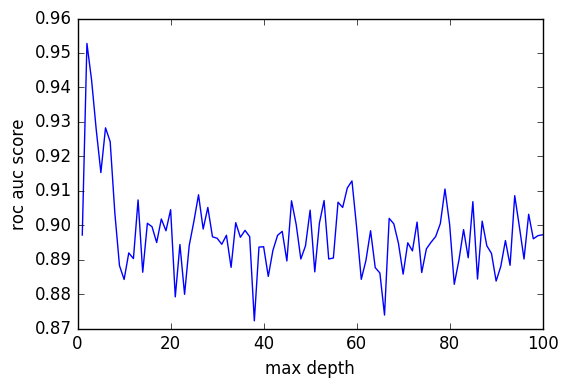

In [21]:
# graph roc_auc_scores vs max depth

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(max_depth_range, roc_auc_scores)
plt.xlabel('max depth')
plt.ylabel('roc auc score')

plt.rcdefaults()

In [22]:
sorted(zip(roc_auc_scores, max_depth_range), reverse=True)[0]

(0.95275501672240792, 2)

In [23]:
# fit tree using max depth of 3

treeclass = DecisionTreeClassifier(max_depth=3)
treeclass.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [70]:
# get feature importances

feat_import = pd.DataFrame({'feature': features_df.columns, 'importance': treeclass.feature_importances_})
feat_import.sort_values('importance', ascending=False).head()

,feature,importance
5088,789=K,0.793847
5097,791=A,0.136087
967,197=R,0.032526
5083,788=D,0.018323
1088,215=E,0.009659


In [71]:
# look at other feature importances at same sites

features_789 = [feat for feat in feat_import.feature if '789' in feat]
features_791 = [feat for feat in feat_import.feature if '791' in feat]

In [72]:
feat_import.set_index('feature', inplace=True)
import_feat = feat_import.transpose()
import_feat[features_789]

feature,789=E,789=K,789=N,789=Q,789=R,789=S,789=T
importance,0,0.793847,0,0,0,0,0


In [73]:
import_feat[features_791]

feature,791=A,791=D,791=E,791=G,791=K,791=N,791=Q,791=S,791=T
importance,0.136087,0,0,0,0,0,0,0,0


# Build Random Forest
    
    Use randomized grid search CV for n_estimators, max_features

In [142]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import RandomizedSearchCV

# foreclass = RandomForestClassifier()

In [143]:
# # define parameter ranges

# estimators_range = range(1, 1500)
# feature_range = range(1, 1350, 20)

In [144]:
# define parameter grid

# param_dist = dict(n_estimators=estimators_range, max_features=feature_range)

In [148]:
# instantiate grid

# rand = RandomizedSearchCV(foreclass, param_dist, n_iter=50, scoring='roc_auc', cv=5)

In [ ]:
# fit the grid

# rand.fit(X, y)

In [147]:
# pd.DataFrame(rand.grid_scores_).sort_values('mean_validation_score', ascending=False)

,parameters,mean_validation_score,cv_validation_scores
18,"{u'n_estimators': 1171, u'max_features': 401}",0.975253,"[0.958674304419, 0.980142140468, 0.97679765886..."
10,"{u'n_estimators': 270, u'max_features': 361}",0.974799,"[0.95437806874, 0.978260869565, 0.982859531773..."
3,"{u'n_estimators': 1044, u'max_features': 461}",0.973963,"[0.957446808511, 0.973244147157, 0.97763377926..."
6,"{u'n_estimators': 397, u'max_features': 981}",0.973417,"[0.96031096563, 0.964882943144, 0.979933110368..."
9,"{u'n_estimators': 105, u'max_features': 1021}",0.972705,"[0.959901800327, 0.96258361204, 0.98097826087,..."
2,"{u'n_estimators': 137, u'max_features': 681}",0.972462,"[0.955400981997, 0.972617056856, 0.97575250836..."
8,"{u'n_estimators': 721, u'max_features': 541}",0.971964,"[0.953764320786, 0.969690635452, 0.97596153846..."
12,"{u'n_estimators': 353, u'max_features': 701}",0.971783,"[0.957446808511, 0.963419732441, 0.97930602006..."
7,"{u'n_estimators': 1373, u'max_features': 581}",0.971633,"[0.953150572831, 0.964673913043, 0.97826086956..."
16,"{u'n_estimators': 1392, u'max_features': 1281}",0.971163,"[0.956628477905, 0.966764214047, 0.97700668896..."


In [94]:
# # look at best parameters

# print rand.best_score_
# print rand.best_params_

0.974660430599
{'n_estimators': 30, 'max_features': 601, 'max_depth': 17}


In [ ]:
# to finish on this notebook:

#     run randomized grid search for best parameters
#     graph n_estimators range vs. score
#     do MCC on each of first 3 features in model individually and in combination?
#     evaluate oob error

# Fit Logistic Regression with best features

    Evaluate with different iterations of selected features
    

In [75]:
# define new df with selected features & perform train/test split

selected_features = ['789=K', '791=A', '197=R']
X = features_df[selected_features]
y = neutdf.is_neutralized

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)

In [76]:
# fit logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [77]:
# look at coefficients

print logreg.coef_

[[ 5.24036648  3.24935764  1.45882361]]


In [78]:
# evaluate log loss

from sklearn import metrics

y_pred_proba = logreg.predict_proba(X_test)
print metrics.log_loss(y_test, y_pred_proba)

0.14960546368


In [79]:
# evaluate MCC

y_pred_class = logreg.predict(X_test)
print metrics.matthews_corrcoef(y_test, y_pred_class)

0.892434769205


In [80]:
# do above with different feature combinations

feature_selections = [['197=R'], ['791=A'], ['789=K'], ['789=K', '791=A'], ['791=A', '197=R'], 
                      ['789=K', '197=R'], ['789=K', '791=A', '197=R']]

log_loss_scores = []
MCC_scores = []

for selection in feature_selections:
    X = features_df[selection]
    y = neutdf.is_neutralized
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)
    y_pred_proba = logreg.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, y_pred_proba)
    y_pred_class = logreg.predict(X_test)
    MCC = metrics.matthews_corrcoef(y_test, y_pred_class)
    log_loss_scores.append(log_loss)
    MCC_scores.append(MCC)

In [84]:
# make a dataframe of the above

log_reg_eval = pd.DataFrame({'features': feature_selections, 'log loss': log_loss_scores, 'MCC': MCC_scores})
log_reg_eval.sort_values('MCC', ascending=False)

,MCC,features,log loss
6,0.878131,"[789=K, 791=A, 197=R]",0.220077
3,0.825113,"[789=K, 791=A]",0.210621
2,0.777919,[789=K],0.347554
5,0.765735,"[789=K, 197=R]",0.348037
4,0.659631,"[791=A, 197=R]",0.449359
1,0.644574,[791=A],0.472282
0,0.000000,[197=R],0.678975
